In [16]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms as T

import os
from PIL import Image
import matplotlib.pyplot as plt
import json
from torch.utils.data import Dataset
from torchvision.transforms import functional as F

from pycocotools import mask as coco_mask
import numpy as np

from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

In [2]:
import torch.multiprocessing
torch.multiprocessing.set_start_method('spawn', force=True)

In [3]:
def get_model_instance_segmentation(num_classes):
    # Load a pre-trained model for instance segmentation
    model = maskrcnn_resnet50_fpn(pretrained=True)

    # Replace the classifier with a new one, that has the number of classes which is user-defined
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # And replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model


In [4]:
# Assuming you have 4 classes for water plus the background
num_classes = 5

# Get the model using our helper function
model = get_model_instance_segmentation(num_classes)

/home/jpjon/miniconda3/envs/aqua/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jpjon/miniconda3/envs/aqua/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [6]:
# Put the model in training mode
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [7]:
class WaterDataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        self.images = self.annotations['images']
        self.categories = {category['id']: category['name'] for category in self.annotations['categories']}

    def __getitem__(self, idx):
        # Load the image
        img_info = self.images[idx]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        
        # Load the annotations
        annotations = [ann for ann in self.annotations['annotations'] if ann['image_id'] == img_info['id']]
        
        # Initialize masks, boxes, and labels
        masks = []
        boxes = []
        labels = []
        for ann in annotations:
            # COCO bbox format is [x_min, y_min, width, height]
            x_min, y_min, w, h = ann['bbox']
            assert w > 0 and h > 0, "Width and Height must be positive"
            boxes.append([x_min, y_min, x_min + w, y_min + h])  # Convert to [x_min, y_min, x_max, y_max] format

            labels.append(ann['category_id'])
            masks.append(coco_to_mask(ann['segmentation'], img_info['height'], img_info['width']))
        
        # Convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.stack(masks, dim=0)
        
        # Create a dictionary for the targets
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        
        # Apply the transformations to the image and masks
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.images)
    
# Define the get_transform function
def get_transform(train):
    transforms = []
    # Converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # During training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Define a transform function that can handle both image and target
class ComposeTransforms(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# Define a custom transform that applies ToTensor to both image and target
class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        # No need to convert masks if they are already tensors
        return image, target

# Define a custom transform that applies RandomHorizontalFlip to both image and target
class RandomHorizontalFlip(object):
    def __call__(self, image, target):
        if torch.rand(1) < 0.5:
            image = F.hflip(image)
            target["masks"] = torch.stack([F.hflip(mask) for mask in target["masks"]])
        return image, target
    
def coco_to_mask(segmentation, height, width):
    """
    Convert COCO polygon segmentation to a binary mask.
    
    :param segmentation: COCO format segmentation data.
    :param height: height of the image/mask.
    :param width: width of the image/mask.
    :return: binary mask as a torch tensor.
    """
    # In case segmentation is in RLE (Run Length Encoding) format
    if isinstance(segmentation, list):
        # Polygon -- a single object might have multiple parts
        # We merge all parts to build the final mask
        rles = coco_mask.frPyObjects(segmentation, height, width)
        rle = coco_mask.merge(rles)
    elif isinstance(segmentation['counts'], list):
        # Uncompressed RLE
        rle = coco_mask.frPyObjects(segmentation, height, width)
    else:
        # RLE
        rle = segmentation
    mask = coco_mask.decode(rle)
    
    # If mask has an extra third dimension, remove it
    if len(mask.shape) == 3:
        mask = mask[:, :, 0]
    # Convert numpy array to torch tensor
    tensor_mask = torch.as_tensor(mask, dtype=torch.uint8)
    
    return tensor_mask


In [9]:
# Use our dataset and defined transformations
dataset = WaterDataset(
    root='images',
    annotation_file='coco_labels.json',
    transforms=ComposeTransforms([ToTensor(), RandomHorizontalFlip()])
)
dataset_test = WaterDataset(
    root='images',
    annotation_file='coco_labels.json',
    transforms=ComposeTransforms([ToTensor(), RandomHorizontalFlip()])
)

# Split the dataset into train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
# Assuming 80-20 split for train-validation
train_indices = indices[:int(len(indices) * 0.8)]
test_indices = indices[int(len(indices) * 0.8):]

# Define the train and validation datasets
dataset = torch.utils.data.Subset(dataset, train_indices)
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

def collate_fn(batch):
    images, targets = tuple(zip(*batch))
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    return images, targets

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=collate_fn)

In [10]:
# Define the optimizer
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# And the learning rate scheduler
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [14]:
# Assume the model, optimizer, and data loaders are already defined and initialized

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

num_epochs= 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
        # Ensure all boxes have positive width and height
        for target in targets:
            boxes = target['boxes']
            assert (boxes[:, 2] > boxes[:, 0]).all(), "Not all boxes have positive width"
            assert (boxes[:, 3] > boxes[:, 1]).all(), "Not all boxes have positive height"
            
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimize
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()

    # Print loss statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader)}')

    # Validation loop
    model.eval()  # switch to evaluation mode
    validation_loss = 0.0
    for images, targets in data_loader_test:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            # Forward pass
            outputs = model(images, targets)
            
            # In training mode, model returns a dict of losses. In eval mode, it returns detections.
            # We need to switch model to training mode to calculate validation loss
            model.train()
            loss_dict = model(images, targets)
            model.eval()
            
            losses = sum(loss for loss in loss_dict.values())
            validation_loss += losses.item()

    # Print validation loss statistics
    validation_loss /= len(data_loader_test)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {validation_loss}')

    # Step the learning rate scheduler
    lr_scheduler.step()

Epoch [1/3], Loss: 0.8276571184396744
Epoch [1/3], Validation Loss: 0.8128063052892684
Epoch [2/3], Loss: 0.8133725166320801
Epoch [2/3], Validation Loss: 0.8424405008554459
Epoch [3/3], Loss: 0.8171542853116989
Epoch [3/3], Validation Loss: 0.8096637934446335


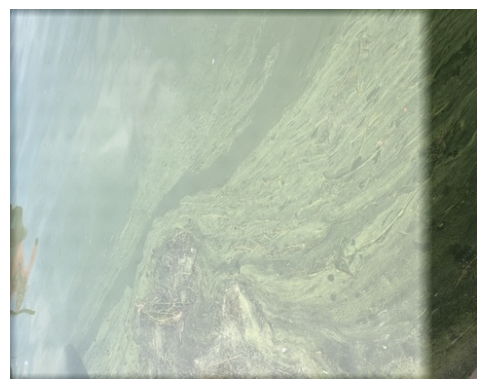

In [31]:
# Load the image
image_path = '5A8011~1.PNG'
image = Image.open(image_path).convert("RGB")

# Convert the image to a tensor
image_tensor = F.to_tensor(image).unsqueeze_(0).to(device) # Add a batch dimension

# Put the model in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    prediction = model(image_tensor)

# The prediction is a list of dictionaries, one for each input image
output = prediction[0]

# Extract the masks, bounding boxes, and labels
masks = output['masks'].detach().cpu().numpy()
boxes = output['boxes'].detach().cpu().numpy()
labels = output['labels'].detach().cpu().numpy()

# # You can set a threshold to only keep detections with a high score
# score_threshold = 0.8
# high_scores_idxs = output['scores'].detach().cpu().numpy() > score_threshold
# masks = masks[high_scores_idxs]
# boxes = boxes[high_scores_idxs]
# labels = labels[high_scores_idxs]

# # Now you can visualize the results or further process them

mask = masks[0, 0]  # Take the first mask and squeeze the channel dimension

plt.imshow(image)  # Show the original image
plt.imshow(mask, alpha=0.5, cmap='gray')  # Overlay the first mask with transparency
plt.axis('off')  # Turn off the axis
plt.show()

In [32]:
labels

array([3, 2, 2, 3, 3, 2, 3, 2, 3, 2, 2, 3, 4, 3, 4, 2, 2, 2, 2, 4, 3, 4,
       3, 4, 4, 2, 4, 2, 4, 1, 3, 1, 1, 4, 1, 4, 1, 4, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1])